<a href="https://colab.research.google.com/github/hawad416/quantumcomputing/blob/main/QubitMapping_simpiflied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qubit Mapping Problem

In [ ]:
# install the qiskit runtime
!pip install qiskit ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 19.8 MB/s eta 0:00:00


## 1. Prerequisite Quantum Background (~10 min)

### 1.1 Generalized GHZ Circuit (~5min)

Let us revisit the circuit for preparing the generalized GHZ state: $\vert 00\cdots 0\rangle \to \frac{1}{\sqrt{2}}(\vert 00\cdots 0\rangle + \vert 11\cdots 1\rangle)$.

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_coupling_map
num_qubit = 5
qc = QuantumCircuit(num_qubit)
qc.h(0)
qc.cx(0,1)
qc.cx(1,4)
qc.cx(0,3)
qc.cx(3,2)
qc.draw()

┌───┐                    
q_0: ┤ H ├──■─────────■───────
     └───┘┌─┴─┐       │       
q_1: ─────┤ X ├──■────┼───────
          └───┘  │    │  ┌───┐
q_2: ────────────┼────┼──┤ X ├
                 │  ┌─┴─┐└─┬─┘
q_3: ────────────┼──┤ X ├──■──
               ┌─┴─┐└───┘     
q_4: ──────────┤ X ├──────────
               └───┘

### 1.2. Superconducting Quantum Devices (~5min)

#### Square Connected Device

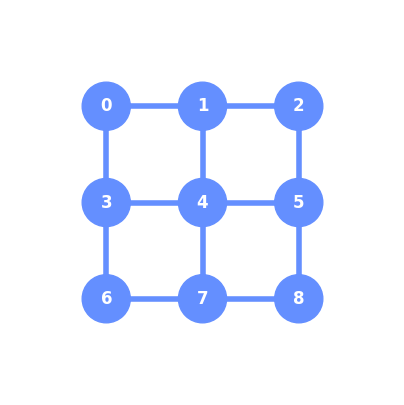

In [ ]:
num_device_qubits = 9
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
coupling_map = [[0, 1], [1, 2], [0, 3], [1, 4], [2, 5], [3, 4], [4, 5], [6, 7], [7, 8], [3, 6], [4, 7], [5, 8]]
plot_coupling_map(num_device_qubits, qubit_coordinates, coupling_map)

A superconducting quantum device is often characterized by its coupling graph, as shown in the figure above. The coupling map defines the connectivity between physical qubits. We can perform a CX gate only on two neighboring physical qubits, i.e., two physical qubits connected by one edge (e.g., $q_0$ and $q_1$ in the figure above).

#### Linear Connected Device

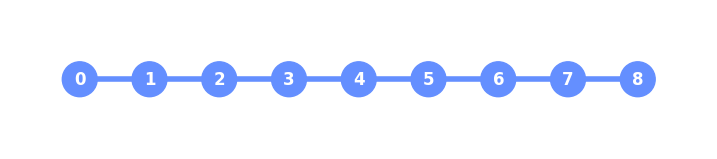

In [ ]:
num_device_qubits = 9
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8]]
coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]
plot_coupling_map(num_device_qubits, qubit_coordinates, coupling_map)

## 2. Mapping Circuit Qubits to Device Qubits (~30min)

To execute the quantum circuit on the quantum device, the first step is to map the logical qubits of the quantum circuit to the physical qubits on the quantum device.

We first look at an example of qubit mapping and then introduce how to evalute the quality of one **qubit mapping** between the quantum circuit and the quantum device.

### 2.1 Evaluation of Qubit Mapping (~10min)

Before we start to map circuit qubits on device, we should know whether a mapping is good or not, so that we know how to further tweak the performance of one mapping.

One general form of loss function for qubit mapping

$$L(M, D, S, P, circ) = \sum_{P_i\in P(circ)}\sum_{CX_{jk}\in P_i} S(i)D(M(q_j),M(q_k)),$$

The notations are explained as follows,
- $P$ is a partition function that divides the quantum circuit into a series of subcircuits $P_i$. Note that subcircuits $P_i$ are ordered according to their occurence ordering in the original quantum circuit. A commonly used partition function $P$ is the as soon as possible layering of the quantum circuit. We would elaborate on it later.

- $S(i)$ is the penality function for the ocurrence ordering $i$ of subscircuit $P(i)$. Generally, we believe the effect of one qubit mapping should decay as we go deeper in the circuit. A commonly used penality function is $S(i) = e^{-i}$.

- $M$ is the qubit mapping function that maps the circuit qubit to the device qubit. For example, if $q_i$ is a logical qubit in the quantum circuit, $M(q_i)$ is a physical qubit on the quantum computer.

- $D(M(q_i), M(q_j))$ quantifies the cost of performing the **CX** gate on physical qubits $M(q_i)$ and $M(q_j)$. Note that, in the superconducting quantum computer, if we want to perform a CX gate between non-neighboring physical qubits $M(q_i)$ and $M(q_j)$, we need to move the qubit information of $M(q_i)$ and $M(q_j)$ close to each other. Thus, one commonly used $D(M(q_i), M(q_j))$ is **the length of the shortest path** between $M(q_i)$ and $M(q_j)$ in the coupling graph of the underlying quantum device.

Generally, we prefer a qubit mapping method with a smaller loss $L$.

Let's first implement a parition function that divides a circuit into layers according to the earliest execution time slot of each gate.

In [ ]:
# ~2min
# Partition Function P
ghz_circ = [('H',0),('CX',0,1),('CX',1,4),('CX',0,3),('CX',3,2)] # Each gate: H, 0 --> Hadamard gate on qubit 0
def partition_func(circ):
    num_qubit = max([max(g[1:]) for g in circ]) + 1

    ############# find the ealiest time slot for each gate to execute #############
    # initilize qubit_tick and gate_tick as all zeros
    qubit_tick = [0 for i in range(num_qubit)] # current available time slot of each qubit to assign gate
    gate_tick = [0 for g in circ] # the time slot to execute one gate
    for i, g in enumerate(circ): # enumerate gate g of circ
        cur_ticks = max([qubit_tick[q] for q in g[1:]]) # get current available time slot to assign gate
        gate_tick[i] = cur_ticks # assign the gate to the current time slot
        # print('\ti={}, g={}:\n\t\tqubit_tick={}\tgate_tick={}'.format(i,g, qubit_tick, gate_tick))
        for q in g[1:]:
            qubit_tick[q] = cur_ticks + 1 # increment the next available time slot of each qubit in the assigned gate
    depth = max(qubit_tick) # the total number of time slot needed to execute the circuit

    ############# partition the gates according to their time slots #############
    layered_circ = [[] for i in range(depth)]
    for i, g in enumerate(circ):
        layered_circ[gate_tick[i]].append(g) # partition the circuit according to time slots
    return layered_circ


layered_circ = partition_func(circ)
for i, layer in enumerate(layered_circ):
    print(f'Layer {i+1}: {layer}') # show the layered circuit

Layer 1: [('H', 0)]
Layer 2: [('CX', 0, 1)]
Layer 3: [('CX', 1, 4), ('CX', 0, 3)]
Layer 4: [('CX', 3, 2)]


We can separate the layers with barriers and draw the circuit again

In [ ]:
def to_layered_qiskit_circuit(layered_circ, num_qubit):
    qc = QuantumCircuit(num_qubit)
    for layer in layered_circ:
        # add all gates of a layer
        for g in layer:
            if g[0] == 'H':
                qc.h(g[1])
            elif g[0] == 'CX':
                qc.cx(g[1],g[2])
            else:
                pass
        # add a barrier for each layer
        qc.barrier(range(num_qubit))
    return qc

qc = to_layered_qiskit_circuit(layered_circ, 5)
qc.draw()

┌───┐ ░       ░            ░       ░ 
q_0: ┤ H ├─░───■───░────────■───░───────░─
     └───┘ ░ ┌─┴─┐ ░        │   ░       ░ 
q_1: ──────░─┤ X ├─░───■────┼───░───────░─
           ░ └───┘ ░   │    │   ░ ┌───┐ ░ 
q_2: ──────░───────░───┼────┼───░─┤ X ├─░─
           ░       ░   │  ┌─┴─┐ ░ └─┬─┘ ░ 
q_3: ──────░───────░───┼──┤ X ├─░───■───░─
           ░       ░ ┌─┴─┐└───┘ ░       ░ 
q_4: ──────░───────░─┤ X ├──────░───────░─
           ░       ░ └───┘      ░       ░

Then we define a penalty function that decays exponential with the layer number.

In [ ]:
# ~0.5min
# Penalty function S
def penalty_func(i): return 2.718**(-1*i) # higher layer number, less weight
print(penalty_func(0))

1.0


For each pair of physical qubit (M(q_i), M(q_j)), we can find their shortest path in the coupling graph.

In [ ]:
# ~1min
# CX Cost Function D(q'_i,q'_j), q'_i=M(q_i), q'_j=M(q_j).
def dijkstra_algorithm(source, destination, graph):
    maxsize = 100000
    num_node = len(graph) # graph is the adjacency matrix
    dist = [maxsize for i in range(num_node)] # the distance from the source node
    visited = [False for i in range(num_node)] # if this node is visited or not
    dist[source] = 0 # start searching from source node
    for count in range(num_node):
        # find the node which is closest to the source node
        # among unvisted node according to previous computation
        min_val = maxsize
        for v in range(num_node):
            if visited[v] == False and dist[v] < min_val:
                min_val = dist[v]
                min_index = v
        visited[min_index] = True # mark this node is already visited
        # update the distance according to the new visited node
        for v in range(num_node):
            if graph[min_index][v] > 0 and visited[v] == False:
                if dist[v] > dist[min_index]+graph[min_index][v]:
                    dist[v] = dist[min_index]+graph[min_index][v]
        if visited[destination] == True: # the search ends at destination node
            break
    return dist[destination]

def cx_dist_func(q_a, q_b, coupling_map): # the dijkstra's algorithm
    num_physical_qubit = max([max(edge[:2]) for edge in coupling_map])+1 # the number of physical qubits on quantum device
    graph = [[0 for i in range(num_physical_qubit)] for j in range(num_physical_qubit)] # adjacency matrix
    for edge in coupling_map:
        graph[edge[0]][edge[1]] = 1
        graph[edge[1]][edge[0]] = 1
    return dijkstra_algorithm(q_a, q_b, graph) - 1

#Let's try it on the linear coupling map
coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]
print(coupling_map)
cx_dist_func(0,8,coupling_map)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]


7

The loss function of a mapping can be calculated by summing the distances of all qubit pairs weighted by corresponding penalties.

In [ ]:
# ~0.5min
# Loss function
def loss_for_mapping(partition_func, penalty_func, dist_func, mapping_func, circuit, coupling_map):
    parted_circuit = partition_func(circuit)
    loss_val = 0
    mapped_qubit = mapping_func(circ, coupling_map)
    for i, subcirc in enumerate(parted_circuit):
        for g in subcirc: # enumerate gate g of subcirc
            if g[0] in ['CX']: # two-qubit gate
                q_a_physical = mapped_qubit[g[1]] # physical qubit
                q_b_physical = mapped_qubit[g[2]] # physical qubit
                loss_val += penalty_func(i)*dist_func(q_a_physical, q_b_physical, coupling_map)
    return loss_val

### 2.2 Exploration of Qubit Mapping Functions

#### Optimal Qubit Mapping (~3min)

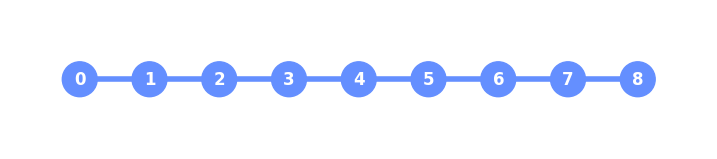

In [ ]:
num_device_qubits = 9
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8]]
coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]
plot_coupling_map(num_device_qubits, qubit_coordinates, coupling_map)

In [ ]:
#ghz_circ = [('H',0),('CX',0,1),('CX',1,4),('CX',0,3),('CX',3,2)]
linear_device_coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]

def manual_mapping_func(circuit, coupling_map):
    return [2,1,4,3,0]

print(loss_for_mapping(partition_func, penalty_func, cx_dist_func, manual_mapping_func, ghz_circ, linear_device_coupling_map))

0.0


#### Naive Qubit Mapping (~1min)

In [ ]:
def simple_mapping_func(circuit, coupling_map):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1
    return [i for i in range(num_circ_qubits)] # naive mapping

print(loss_for_mapping(partition_func, penalty_func, cx_dist_func, simple_mapping_func, ghz_circ, linear_device_coupling_map))

0.5414534017080689


#### Random Qubit Mapping (~1min)

In [ ]:
def random_mapping_func(circuit, coupling_map, seed=100):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1
    physical_qubits = []
    for edge in coupling_map:
        for qb in edge:
            if qb not in physical_qubits:
                physical_qubits.append(qb)
    import random
    random.seed(seed)
    random.shuffle(physical_qubits)
    #print(physical_qubits)
    return [physical_qubits[i] for i in range(num_circ_qubits)]

loss_sum = 0
trial_count = 10
for i in range(trial_count):
    random_mapping_func_seeded = lambda circuit,coupling_map: random_mapping_func(circuit, coupling_map, seed=i)
    loss_per_run = loss_for_mapping(partition_func, penalty_func, cx_dist_func, random_mapping_func_seeded, ghz_circ, linear_device_coupling_map)
    print("random iteration:", loss_per_run)
    loss_sum += loss_per_run
print("averaged:", loss_sum/trial_count)

random iteration: 0.8238101949260175
random iteration: 0.37033181522270053
random iteration: 0.8711985233482828
random iteration: 1.6234922461575982
random iteration: 1.3536335042701721
random iteration: 0.6768167521350861
random iteration: 1.6833786259103862
random iteration: 2.518818913200318
random iteration: 1.5644738253714188
random iteration: 1.2913328957553163
averaged: 1.2777287296297295


### 2.3 Qiskit Mapping Algorithms
Let's look at some qubit mapping algorithms supported by Qiskit package.

#### Qiskit: SABRE Qubit Mapping (~5min)

First, we use the SABRE mapping, which is one of standard qubit mapping methods in Qiskit.

In [ ]:
# The example of Qiskit SABRE mapping
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import SabreLayout
from qiskit.transpiler import PassManager

# the GHZ state preparation circuit
num_qubit = 5
qc = QuantumCircuit(num_qubit)
qc.h(0)
qc.cx(0,1)
qc.cx(1,4)
qc.cx(0,3)
qc.cx(3,2)

coupling_map = CouplingMap(couplinglist=linear_device_coupling_map)

sl = SabreLayout(coupling_map=coupling_map) # SABRE qubit mapping algorithm
pass_manager = PassManager(sl)
mapped_circ = pass_manager.run(qc)

In [ ]:
mapped_circ.draw()

ancilla_0 -> 0 ────────────────────
                                   
ancilla_1 -> 1 ────────────────────
                         ┌───┐     
      q_4 -> 2 ──────────┤ X ├─────
                    ┌───┐└─┬─┘     
      q_1 -> 3 ─────┤ X ├──■───────
               ┌───┐└─┬─┘          
      q_0 -> 4 ┤ H ├──■────■───────
               └───┘     ┌─┴─┐     
      q_3 -> 5 ──────────┤ X ├──■──
                         └───┘┌─┴─┐
      q_2 -> 6 ───────────────┤ X ├
                              └───┘
ancilla_2 -> 7 ────────────────────
                                   
ancilla_3 -> 8 ────────────────────

In [ ]:
# Let's inspect the qubit mapping result of Qiskit
# Interpretation:
# Qubit(QuantumRegister(5, 'q'), 0): 4 indicates that the circuit qubit 0 (among the 5 circuit qubits) is on device physical qubit 4

mapped_circ.layout.initial_layout.get_virtual_bits()



{Qubit(QuantumRegister(5, 'q'), 0): 4,
 Qubit(QuantumRegister(5, 'q'), 1): 3,
 Qubit(QuantumRegister(5, 'q'), 2): 6,
 Qubit(QuantumRegister(5, 'q'), 3): 5,
 Qubit(QuantumRegister(5, 'q'), 4): 2,
 Qubit(QuantumRegister(4, 'ancilla'), 0): 0,
 Qubit(QuantumRegister(4, 'ancilla'), 1): 1,
 Qubit(QuantumRegister(4, 'ancilla'), 2): 7,
 Qubit(QuantumRegister(4, 'ancilla'), 3): 8}

In [ ]:
# Wrap Qiskit SABRE Code
ghz_circ = [('H',0), ('CX',0,1), ('CX',1,4), ('CX',0,3), ('CX',3,2)]

def SABRE_mapping_qiskit(circuit, coupling_map):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1
    qc = QuantumCircuit(num_circ_qubits)
    for g in circuit:
        if g[0] == 'H':
            qc.h(g[1])
        elif g[0] == 'CX':
            qc.cx(g[1], g[2])
        else:
            pass # add new conversion rules as you like
    coupling_map = CouplingMap(couplinglist=coupling_map)
    sl = SabreLayout(coupling_map=coupling_map) # SABRE qubit mapping algorithm
    pass_manager = PassManager(sl)
    mapped_circ = pass_manager.run(qc)


    mapping_dict = {} # circuit qubit --> physical qubit
    for qb in range(num_circ_qubits):
        mapping_dict[qb] = -1

    count = 0
    for k, v in mapped_circ.layout.initial_layout.get_virtual_bits().items():
       # print(k, v)
        lqb = int(str(k)[:-1].split()[-1])
        count = count + 1
        if count <= num_qubit:
          mapping_dict[lqb] = v
        #  print(k, v, lqb)
    return [mapping_dict[qb] for qb in range(num_circ_qubits)]

print('The qubit mapping by SABRE is:',)
print( SABRE_mapping_qiskit(ghz_circ, linear_device_coupling_map))
print('\nThe corresponding loss is:',)
loss_for_mapping(partition_func, penalty_func, cx_dist_func, SABRE_mapping_qiskit, ghz_circ, linear_device_coupling_map)

The qubit mapping by SABRE is:
[6, 7, 4, 5, 8]

The corresponding loss is:


0.3205292580383675

#### Graph Theory Based Qubit Mapping (~10min)

For visualization, we define a function of drawing coupling graphs.

In [ ]:
import networkx as nx
def draw_graph(nodes, edges):
    G = nx.Graph()
    if nodes != None:
        G.add_nodes_from(nodes)
    if edges != None:
        G.add_edges_from(edges)
    pos=nx.spring_layout(G)
    # draw custom node color
    color_map_dict = nx.get_node_attributes(G,"color")
    color_map = []
    for v in G.nodes:
        if v in color_map_dict:
            color_map.append(color_map_dict[v])
        else:
            color_map.append('gray')
    nx.draw_networkx_nodes(G, pos,node_color=color_map)
    nx.draw_networkx_edges(G, pos)
    # nx.draw_networkx(G,pos,node_color=color_map)
    # draw custom node label
    node_label_map_dict = nx.get_node_attributes(G,"label")
    for v in G.nodes:
        if v not in node_label_map_dict:
            node_label_map_dict[v] = str(v)
    nx.draw_networkx_labels(G, pos, node_label_map_dict)
    # draw custom edge weight
    weight_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=weight_labels)

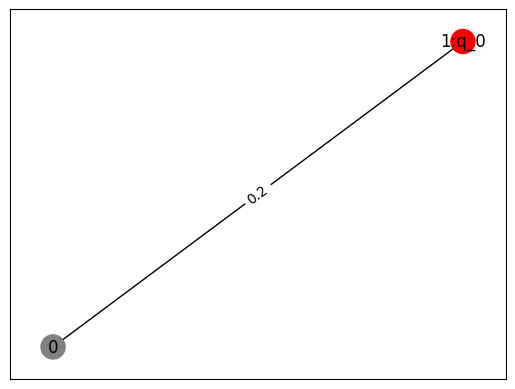

In [ ]:
draw_graph([(1,{'color': 'red', 'label': '1:q_0'})],[(0,1,{'weight':0.2})])

When the number of qubits in the circuit is larger than the number of physical qubits on the chip, we want to find a connected sub coupling graph with max connections for qubit mapping. Here we first find the node with the max degree in the coupling graph, and from that node, search for a maximally connected subgraph by adding the nodes with max connections.

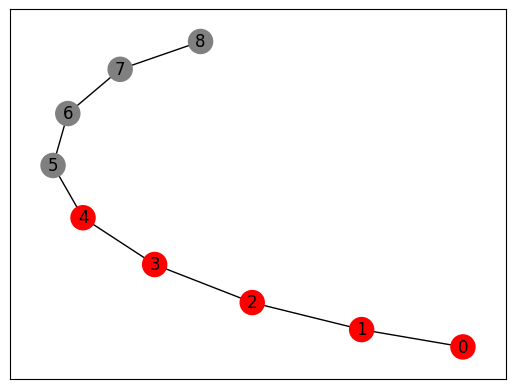

In [ ]:
# find a maximally connected sub graph (with num_selected_node nodes) from coupling_map for qubit mapping
def get_maximally_connected_subgraph(coupling_map, num_selected_node):
    num_nodes = max([max(edge[:2]) for edge in coupling_map])+1
    graph = [[0 for i in range(num_nodes)] for j in range(num_nodes)] # adjacency matrix
    for edge in coupling_map:
        graph[edge[0]][edge[1]] = 1
        graph[edge[1]][edge[0]] = 1
    selected_nodes = []

    # find the the node with the max degree
    max_val = 0
    for v in range(num_nodes):
        if sum(graph[v]) > max_val:
            max_val = sum(graph[v])
            max_index = v
    selected_nodes = [max_index]

    # Start searching from node max_index
    for i in range(num_selected_node-1):
        connected_degree = 0
        # find the node that has max connections with selected_nodes
        for v in range(num_nodes):
            if v not in selected_nodes:
                s = sum([graph[v][v1] for v1 in selected_nodes])
                if s > connected_degree:
                    connected_degree = s
                    v_index = v
        # add the maximally connected node to selected_nodes
        selected_nodes.append(v_index)
        if len(selected_nodes) == num_selected_node:
            break
    return selected_nodes

linear_device_coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]
num_circ_qubits = 5
selected_nodes = get_maximally_connected_subgraph(linear_device_coupling_map, num_circ_qubits)

draw_graph([(v, {'color':'red'}) for v in selected_nodes], linear_device_coupling_map) # plot selected subgraph for mapping circuit qubits

Now we can do the qubit mapping. We first construct a circuit qubit interaction graph to store the penalty factor of each qubit pair in a CX gate. Then we implement an algorithm that maps circuit qubits of higher connectivity to physical qubits of higher connectivity.

In [ ]:
# construct circuit qubit interaction graph circ_graph to store the penalty factor of each qubit pair in a CX gate
def get_circuit_interaction_graph(input_circuit):
    num_circ_qubits = max([max(g[1:]) for g in input_circuit]) + 1
    #print(num_circ_qubits)
    # construct circuit qubit interaction graph
    circ_graph = [[0 for i in range(num_circ_qubits)] for j in range(num_circ_qubits)]
    qubit_tick = [0 for i in range(num_circ_qubits)] # current available time slot of each qubit to assign gate
    for g in input_circuit: # enumerate gate g of circ
        cur_ticks = max([qubit_tick[q] for q in g[1:]]) # current available time slot to assign gate
        for q in g[1:]:
            qubit_tick[q] = cur_ticks + 1 # next available time slot of each qubit to assign gate
        if g[0] in ['CX']: # if two-qubit gate
            circ_graph[g[1]][g[2]] += 2.718**(-(cur_ticks-1)) # the edge weight by gate g
            circ_graph[g[2]][g[1]] = circ_graph[g[1]][g[2]]
           # print("g[1], g[2], cur_ticks):", g[1], g[2], cur_ticks, circ_graph[g[2]][g[1]])
    return circ_graph


#random_circ = [('H',0), ('H',4), ('CX',0,1),('CX',2,4),('CX',0,5),('CX',4,3)] # Each gate: H, 0 --> Hadamard gate on qubit 0
print(get_circuit_interaction_graph(ghz_circ))
# print(get_circuit_interaction_graph(random_circ))

[[0, 1.0, 0, 0.36791758646063283, 0], [1.0, 0, 0, 0, 0.36791758646063283], [0, 0, 0, 0.13536335042701722, 0], [0.36791758646063283, 0, 0.13536335042701722, 0, 0], [0, 0.36791758646063283, 0, 0, 0]]


##### Example for showing how to draw the qubit interaction graph of an example circuit.

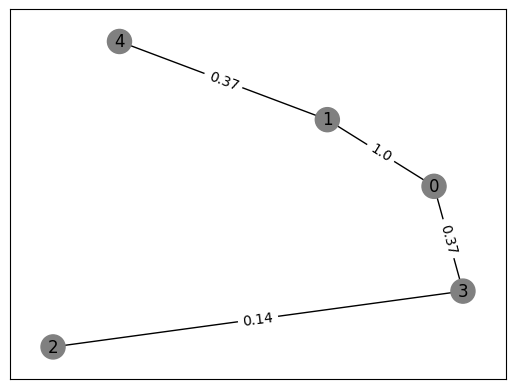

In [ ]:
# plot the qubit interaction graph of the circuit
circ_graph = get_circuit_interaction_graph(ghz_circ)
nodes = [i for i in range(num_circ_qubits)]
edges = []
for i in range(num_circ_qubits):
    for j in range(i, num_circ_qubits):
        if circ_graph[i][j] > 0:
            edges.append((i,j,{'weight':round(circ_graph[i][j],2)}))

draw_graph(nodes, edges)

In [ ]:
# map qubit interaction graph to device coupling graph: higher connectivity circuit qubit --> higher connectivity physical qubit
def graph_circuit_mapping(circuit, coupling_map):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1

    # construct device coupling graph
    num_nodes = max([max(edge[:2]) for edge in coupling_map])+1
    device_graph = [[0 for i in range(num_nodes)] for j in range(num_nodes)] # adjacency matrix
    for edge in coupling_map:
        device_graph[edge[0]][edge[1]] = 1
        device_graph[edge[1]][edge[0]] = 1

    # selected maximally connected physical qubits for mapping circuit qubits
    selected_physical_qubits = get_maximally_connected_subgraph(coupling_map, num_circ_qubits)
    physical_qubit_neighbor_dict = {}
    for i in selected_physical_qubits:
        physical_qubit_neighbor_dict[i] = []
    for i in selected_physical_qubits:
        for j in selected_physical_qubits:
            if device_graph[i][j] > 0:
                physical_qubit_neighbor_dict[i].append(j)

    # construct circuit graph
    circ_graph = get_circuit_interaction_graph(circuit)

    # start to map circuit qubits
    mapping_dict = {}

    # Find the highest degree circuit qubit index qb_index
    max_val = 0
    for qb in range(num_circ_qubits):
        #print("logical", qb, sum(circ_graph[qb]))
        if sum(circ_graph[qb]) > max_val:
            max_val = sum(circ_graph[qb])
            qb_index = qb

    # Find the highest degree selected physical qubit pqb_index
    max_val = 0
    for pqb in selected_physical_qubits:
        #print("physical", pqb,len(physical_qubit_neighbor_dict[pqb]))
        if len(physical_qubit_neighbor_dict[pqb]) > max_val:
            max_val = len(physical_qubit_neighbor_dict[pqb])
            pqb_index = pqb

    visited = {}
    for pqb in selected_physical_qubits:
        visited[pqb] = False
    mapping_dict[qb_index] = pqb_index # assign the highest degree circuit qubit to the highest degree physical qubit
    visited[pqb_index] = True
    #print("highest degree logic qubit", qb_index, "mapped to physical qubit", pqb_index)

    # traverse the circuit qubits in descending order of their interactions
    for qb in sorted(range(num_circ_qubits), key=lambda qb: -sum(circ_graph[qb])):
        #print("Deciding logic qubt", qb, "'s assignment")

        if qb not in mapping_dict:
            # sort the "assigned" qubits in descending order of their interactions with qb
            sorted_qlist = sorted(mapping_dict.keys(), key=lambda mqb: -circ_graph[mqb][qb])
            #print(qb, "'s sorted_qlist", sorted_qlist)

            # place qb to the neighbor of the qubit that has the most interaction with qb
            for mqb in sorted_qlist:
                #print("checking its neighbor ", mqb, "which is physicsally mapped to", mapping_dict[mqb])
                for pqb in physical_qubit_neighbor_dict[mapping_dict[mqb]]:
                    if visited[pqb] == False:
                        mapping_dict[qb] = pqb
                        #print("Finalize logic qubt", qb, "assignment to", pqb)
                        visited[pqb] = True
                        break
            if qb not in mapping_dict: # if we do not find mapping of qb in neighbors
                max_val = 0
                for pqb in selected_physical_qubits:
                    if visited[pqb] == False and len(physical_qubit_neighbor_dict[pqb]) > max_val:
                        max_val = len(physical_qubit_neighbor_dict[pqb])
                        pqb_index = pqb
                        print(pqb, len(physical_qubit_neighbor_dict[pqb]))
                mapping_dict[qb] = pqb_index
                visited[pqb_index] = True
    return [mapping_dict[qb] for qb in range(num_circ_qubits)]


print(graph_circuit_mapping(ghz_circ, linear_device_coupling_map))
loss_for_mapping(partition_func, penalty_func, cx_dist_func, graph_circuit_mapping, ghz_circ, linear_device_coupling_map)

[2, 1, 5, 3, 4]


0.3205292580383675

#### Qiskit: VF2 Layout (~5min)

Second, we use a pass for choosing the qubit mapping of a circuit onto a coupling graph, as a a subgraph isomorphism problem, solved by VF2++. It is one of the qubit mapping methods supported by Qiskit.

##### Key insight is that if we plot qubit interaction graph of the circuit, we may find that there is a subgraph in the hardware coupling graph that matches perfectly well with it.

Let us check the qubit interactiion graph of the example circuit again.


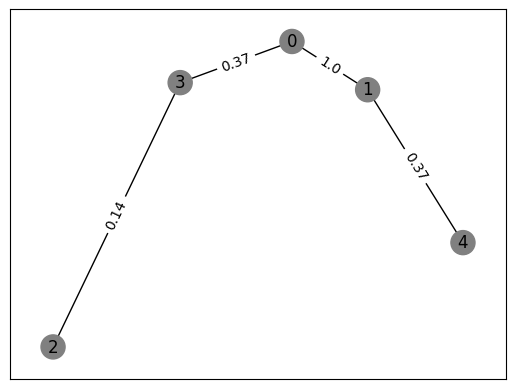

In [ ]:
# plot the qubit interaction graph of the circuit
circ_graph = get_circuit_interaction_graph(ghz_circ)
nodes = [i for i in range(num_circ_qubits)]
edges = []
for i in range(num_circ_qubits):
    for j in range(i, num_circ_qubits):
        if circ_graph[i][j] > 0:
            edges.append((i,j,{'weight':round(circ_graph[i][j],2)}))

draw_graph(nodes, edges)

In [ ]:
# The example of Qiskit VF2 mapping
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import VF2Layout
from qiskit.transpiler import PassManager

# the GHZ state preparation circuit
num_qubit = 5
qc = QuantumCircuit(num_qubit)
qc.h(0)
qc.cx(0,1)
qc.cx(1,4)
qc.cx(0,3)
qc.cx(3,2)

coupling_map = CouplingMap(couplinglist=linear_device_coupling_map)

vf2 = VF2Layout(coupling_map=coupling_map) # VF2 qubit mapping algorithm
pass_manager = PassManager(vf2)
mapped_circ = pass_manager.run(qc)

In [ ]:
mapped_circ.draw()

┌───┐                    
q_2 -> 0 ┤ H ├──■────■────────────
         └───┘┌─┴─┐  │            
q_3 -> 1 ─────┤ X ├──┼────■───────
              └───┘  │    │  ┌───┐
q_0 -> 2 ────────────┼────┼──┤ X ├
                   ┌─┴─┐  │  └─┬─┘
q_1 -> 3 ──────────┤ X ├──┼────■──
                   └───┘┌─┴─┐     
q_4 -> 4 ───────────────┤ X ├─────
                        └───┘

In [ ]:
mapped_circ.layout.initial_layout.get_virtual_bits()

{Qubit(QuantumRegister(5, 'q'), 0): 2,
 Qubit(QuantumRegister(5, 'q'), 1): 3,
 Qubit(QuantumRegister(5, 'q'), 3): 1,
 Qubit(QuantumRegister(5, 'q'), 4): 4,
 Qubit(QuantumRegister(5, 'q'), 2): 0}

[2, 3, 0, 1, 4]


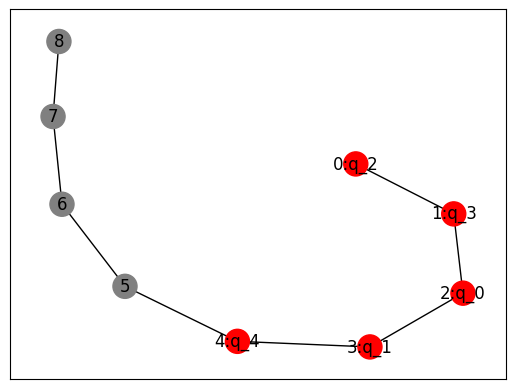

In [ ]:
# Wrap Qiskit VF2 Code
ghz_circ = [('H',0),('CX',0,1),('CX',1,4),('CX',0,3),('CX',3,2)]

def VF2_mapping_qiskit(circuit, coupling_map):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1
    qc = QuantumCircuit(num_circ_qubits)
    for g in circuit:
        if g[0] == 'H':
            qc.h(g[1])
        elif g[0] == 'CX':
            qc.cx(g[1], g[2])
        else:
            pass # add new conversion rules as you like
    coupling_map = CouplingMap(couplinglist=coupling_map)
    vf2 = VF2Layout(coupling_map=coupling_map) # VF2 qubit mapping algorithm
    pass_manager = PassManager(vf2)
    mapped_circ = pass_manager.run(qc)
    mapping_dict = {}
    for qb in range(num_circ_qubits):
        mapping_dict[qb] = -1
    for k, v in mapped_circ.layout.initial_layout.get_virtual_bits().items():
        lqb = int(str(k)[:-1].split()[-1])
        mapping_dict[lqb] = v
    return [mapping_dict[qb] for qb in range(num_circ_qubits)]

physical_qubits = VF2_mapping_qiskit(ghz_circ, linear_device_coupling_map)
print(physical_qubits)
linear_device_coupling_map = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]
draw_graph([(pqb, {'color':'red','label':f"{pqb}:q_{lqb}"}) for lqb,pqb in enumerate(physical_qubits)], linear_device_coupling_map)
# the physical qubit graph is isomorphism to circuit interaction graph

In [ ]:
loss_for_mapping(partition_func, penalty_func, cx_dist_func, VF2_mapping_qiskit, ghz_circ, linear_device_coupling_map)

0.0

#### Qiskit: Noise Adaptive Qubit Mapping (~5min)

This qubit mapping considers the fidelity of coupling between qubits. It is one of the standard qubit mapping method supported by Qiskit.

In [ ]:
# The example of Qiskit NoiseAdaptive mapping

# NoiseAdaptive qubit mapping of qiskit requires Backend instead of Coupling_map
def backend_from_weighted_coupling_map(weighted_coupling_map):
    from qiskit.providers.models.backendproperties import Nduv, Gate
    from qiskit.providers.models import BackendProperties
    import datetime
    curtime = datetime.datetime(2020,8,10)
    # readout error of qubits
    num_physical_qubits = max([max(weighted_edge[:2]) for weighted_edge in weighted_coupling_map]) + 1
    qubits_info = [[Nduv(curtime,'readout_error','',0.0)] for i in range(num_physical_qubits)]
    # cx error of qubits
    gates_info = []
    for weighted_edge in weighted_coupling_map:
        print("Added: ", weighted_edge[:2], weighted_edge[:2][::-1], weighted_edge[2], weighted_edge[0], weighted_edge[1])
        gates_info.append(Gate(weighted_edge[:2],'cx',[Nduv(curtime,'gate_error','',weighted_edge[2])], name=f"cx_{weighted_edge[0]}_{weighted_edge[1]}"))
        gates_info.append(Gate(weighted_edge[:2][::-1],'cx',[Nduv(curtime,'gate_error','',weighted_edge[2])], name=f"cx_{weighted_edge[1]}_{weighted_edge[0]}"))
    backend = BackendProperties('QubitMapping','0.0.1',curtime, qubits_info,gates_info,[])
    return backend

from qiskit.transpiler.passes import NoiseAdaptiveLayout

# the GHZ state preparation circuit
num_qubit = 5
qc = QuantumCircuit(num_qubit)
qc.h(0)
qc.cx(0,1)
qc.cx(1,4)
qc.cx(0,3)
qc.cx(3,2)

weighted_linear_device_coupling_map = [[0,1,0.5], [1,2,0.0], [2,3,0.0], [3,4,0.0], [4,5,0.0], [5,6,0.0], [6,7,0.0], [7,8,0.0]] # [0,1,0.5]: qb0,qb1,error rate of the link
backend = backend_from_weighted_coupling_map(weighted_linear_device_coupling_map)
nal = NoiseAdaptiveLayout(backend) # NoiseAdaptive qubit mapping
pass_manager = PassManager([nal])
mapped_circ = pass_manager.run(qc)

Added:  [0, 1] [1, 0] 0.5 0 1
Added:  [1, 2] [2, 1] 0.0 1 2
Added:  [2, 3] [3, 2] 0.0 2 3
Added:  [3, 4] [4, 3] 0.0 3 4
Added:  [4, 5] [5, 4] 0.0 4 5
Added:  [5, 6] [6, 5] 0.0 5 6
Added:  [6, 7] [7, 6] 0.0 6 7
Added:  [7, 8] [8, 7] 0.0 7 8


In [ ]:
mapped_circ.layout.initial_layout.get_virtual_bits() # coupling 0-1 is avoided in the qubit mapping

{Qubit(QuantumRegister(5, 'q'), 0): 1,
 Qubit(QuantumRegister(5, 'q'), 1): 2,
 Qubit(QuantumRegister(5, 'q'), 2): 5,
 Qubit(QuantumRegister(5, 'q'), 3): 3,
 Qubit(QuantumRegister(5, 'q'), 4): 4}

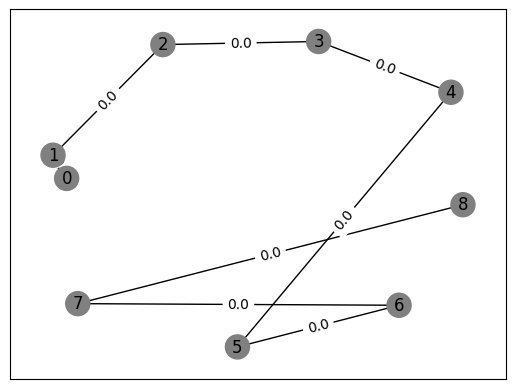

In [ ]:
draw_graph(None, [(edge[0],edge[1],{'weight':edge[2]}) for edge in weighted_linear_device_coupling_map])
# coupling 0-1 should be avoided in the qubit mapping, as it is too noisy (larger weight means less fidelity)

In [ ]:
def weighted_cx_dist_func(q_a, q_b, weighted_coupling_map):
    num_physical_qubit = max([max(weighted_edge[:2]) for weighted_edge in weighted_coupling_map])+1 # the number of physical qubits on quantum device
    graph = [[0 for i in range(num_physical_qubit)] for j in range(num_physical_qubit)] # adjacency matrix
    for weighted_edge in weighted_coupling_map:
        graph[weighted_edge[0]][weighted_edge[1]] = 1 + 10*weighted_edge[2]
        graph[weighted_edge[1]][weighted_edge[0]] = 1 + 10*weighted_edge[2]
    return dijkstra_algorithm(q_a, q_b, graph)

In [ ]:
# Wrap Qiskit NoiseAdaptive Code
ghz_circ = [('H',0),('CX',0,1),('CX',1,4),('CX',0,3),('CX',3,2)]

def NoiseAdaptive_mapping_qiskit(circuit, weighted_coupling_map):
    num_circ_qubits = max([max(g[1:]) for g in circuit]) + 1
    qc = QuantumCircuit(num_circ_qubits)
    for g in circuit:
        if g[0] == 'H':
            qc.h(g[1])
        elif g[0] == 'CX':
            qc.cx(g[1], g[2])
        else:
            pass # add new conversion rules as you like
    backend = backend_from_weighted_coupling_map(weighted_coupling_map)
    nal = NoiseAdaptiveLayout(backend) # NoiseAdaptive qubit mapping
    pass_manager = PassManager([nal])
    mapped_circ = pass_manager.run(qc)
    mapping_dict = {}
    for qb in range(num_circ_qubits):
        mapping_dict[qb] = -1
    for k, v in mapped_circ.layout.initial_layout.get_virtual_bits().items():
        lqb = int(str(k)[:-1].split()[-1])
        mapping_dict[lqb] = v
    return [mapping_dict[qb] for qb in range(num_circ_qubits)]

loss_for_mapping(partition_func, penalty_func, weighted_cx_dist_func, NoiseAdaptive_mapping_qiskit, ghz_circ, weighted_linear_device_coupling_map)

1.0089761025373678

In [ ]:
# because of the noisy coupling between qubits, the original manual qubit mapping is not optimal anymore!
loss_for_mapping(partition_func, penalty_func, weighted_cx_dist_func, manual_mapping_func, ghz_circ, weighted_linear_device_coupling_map)

1.3652635966340865

In [ ]:
# However, we can still get another optimal manual qubit mapping when coupling noise is presented
def manual_mapping_func(circuit, coupling_map): # the original manual qubit mapping where no noise is presented
    return [2,1,4,3,0]
def noise_manual_mapping_func(circuit, coupling_map): # the optimal manual qubit mapping when coupling noise is presented
    return [3,2,5,4,1]
loss_for_mapping(partition_func, penalty_func, weighted_cx_dist_func, noise_manual_mapping_func, ghz_circ, weighted_linear_device_coupling_map)
# this result is better than NoiseAdaptive qubit mapping

0.6884468444990003